In [ ]:
#default_exp audio.core
#default_cls_lvl 3

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import *

In [ ]:
from IPython.display import Audio
import torchaudio
from torchaudio.transforms import MelSpectrogram, MFCC, AmplitudeToDB

# Audio core

> Basic function to preprocess audio data before assembling it in a `DataBunch`.

In [ ]:
URLs.ESC50_SAMPLE = 'https://github.com/limeai/dataset/raw/master/esc50_sample.tgz'

In [ ]:
path = untar_data(URLs.ESC50_SAMPLE)
path.ls()

In [ ]:
t  = get_files(path, extensions='.wav', recurse=True)

In [ ]:
#export
audio_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get audio files in `path` recursively."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
test_eq(len(t), len(get_audio_files(path, recurse=True)))

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_audio_files` partial function that searches path suffix `suf` and passes along `kwargs`"
    def _inner(o, recurse=recurse, folders=folders): return get_audio_files(o/suf, recurse, folders)
    return _inner

In [ ]:
test_eq(len(get_files(path, extensions='.wav', recurse=True, folders='dog')),
        len(AudioGetter(                       recurse=True, folders='dog')(path)))

### Basic Types

In [ ]:
#export
def load_audio(fn, **kwargs):
    "Open and load an audio file"
    signal, sample_rate = torchaudio.load(fn)
    return signal, sample_rate

In [ ]:
#export
class AudioSignal(tuple):
    "Basic type for an audio signal"
    def show(self, ctx=None, **kwargs):
        return display(Audio(data=self.signal, rate=self.sample_rate))
    
    @classmethod
    def create(cls, fn:Path): return cls(load_audio(fn))
    
    signal,sample_rate = add_props(lambda i,self: self[i])

In [ ]:
audio = AudioSignal.create(get_audio_files(path, recurse=True)[0])

In [ ]:
audio.show()

In [ ]:
#export
class AudioSpectrogram(TensorImageBase): pass

#### MelSpectrogram

In [ ]:
@delegates(to=MelSpectrogram)
class MelSpectrogramify(Transform):
    def __init__(self, **kwargs):
        self.transformer = MelSpectrogram(**kwargs)
    def encodes(self, x:AudioSignal): return AudioSpectrogram(self.transformer(x.signal).detach())

In [ ]:
mel = MelSpectrogramify(sample_rate=audio.sample_rate, n_fft=2560)

In [ ]:
mel_spectrogram = mel(audio)

In [ ]:
mel_spectrogram.shape

torch.Size([1, 128, 173])

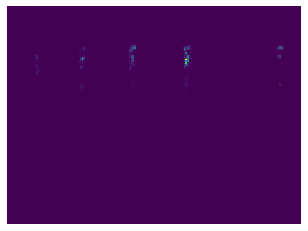

In [ ]:
mel_spectrogram.show()

In [ ]:
#export
@delegates(AmplitudeToDB)
class AmplitudeToDBify(Transform):
    def __init__(self, **kwargs):
        self.transformer = AmplitudeToDB(**kwargs)
    def encodes(self, x:AudioSpectrogram):
        return self.transformer(x)

In [ ]:
amp = AmplitudeToDBify()

In [ ]:
mel_spectrogram_db = amp(mel_spectrogram)

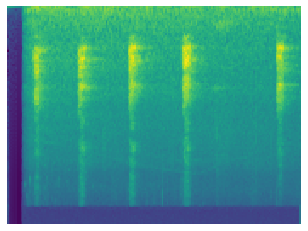

In [ ]:
mel_spectrogram_db.show()

Putting the two together

In [ ]:
mel_args = {'sample_rate': 44100, 'n_fft': 2560}

In [ ]:
audio_fn = get_audio_files(path, recurse=True)[5]

In [ ]:
pipe_audio = Pipeline([AudioSignal.create, MelSpectrogramify(**mel_args), AmplitudeToDBify()], as_item=True)
audio = pipe_audio(audio_fn)

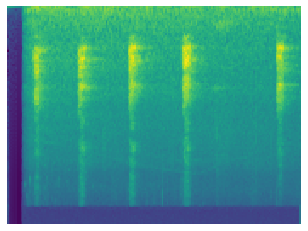

In [ ]:
pipe_audio.show(audio);

#### MFCC

In [ ]:
@delegates(to=MFCC)
class MFCCify(Transform):
    def __init__(self, **kwargs):
        print(kwargs)
        self.transformer = MFCC(**kwargs)
    def encodes(self, x:AudioSignal): return AudioSpectrogram(self.transformer(x.signal).detach())

In [ ]:
mfcc_args = {'sample_rate': 44100, 'melkwargs':{'n_fft': 2560}}

In [ ]:
pipe_audio = Pipeline([AudioSignal.create, MFCCify(**mfcc_args)], as_item=True)
audio = pipe_audio(audio_fn)

{'sample_rate': 44100, 'melkwargs': {'n_fft': 2560}}


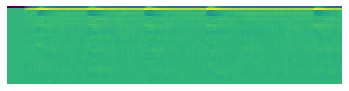

In [ ]:
audio.show()

### Preprocessing rules

In [ ]:
#export
def downmix(): pass # Kevin

In [ ]:
# test stuff

In [ ]:
#export
def resample(): pass # Kevin

In [ ]:
# test stuff

In [ ]:
#export
def remove_silence(): pass # Hiromi

In [ ]:
# test stuff

In [ ]:
#export
defaults.audio_proc_rules = [downmix, resample, remove_silence]

In [ ]:
#export
class PreprocessBatch:
    "Apply `rules` and preprocess in parallel"
    def __init__(self):
        self.rules = L(ifnone(rules, defaults.text_proc_rules))
#         self.post_f = compose(*L(ifnone(post_rules, defaults.text_postproc_rules)))
#         self.tok = tok_func(**tok_kwargs)

    def __call__(self, batch):
        for o in self.tok.pipe(apply_rules(batch, self.rules)): yield L(o).mapped(self.post_f)

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)